In [1]:
%load_ext autoreload
%autoreload 2


# Read in data

In [2]:

from rozlib.libs.plotting.utils_latex_matplot import config_matplot_for_latex
from lib.utils.utils_misc import save_fig
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
from typing import List
from pprint import pp


In [3]:
from paper.exp3_magpie.corpus_magpie import get_all_magpie_json, get_magpie_pretty

"""
Read in data
"""
from paper.exp3_magpie.magpie_processing_helpers import get_all_magpie_results_unclean
# from paper.exp3_magpie.magpie_processing_helpers import load_minicons_score_data

# read in cluster data - includes hhi and surprisal scores
# todo: don't know why but we had some dupes in 0.jsonl??; todo (check whether there were dupes in 0.txt in the input?)
all_magpie_results = get_all_magpie_results_unclean()
print(f"total results: {len(all_magpie_results)}")

# We produced overall sentence scores using minicons - read that in
# all_magpie_minicons_scores = load_minicons_score_data()

# read in original data and then we line up with results
all_magpie_json = get_all_magpie_json()
all_magpie_entries, all_magpie_wrappers = get_magpie_pretty(all_magpie_json)
print(f"magpie json length (should match): {len(all_magpie_json)}")
print("num idioms", len([m for m in all_magpie_entries if m.label == 'i']))



/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


total results: 48395


Token indices sequence length is longer than the specified maximum sequence length for this model (1538 > 512). Running this sequence through the model will result in indexing errors


magpie json length (should match): 48395
num idioms 36328


In [4]:
"""Get POS so that we can filter on POS
"""
from paper.exp3_magpie.magpie_processing_helpers import get_all_pos_for_magpie, get_all_pos_for_magpie_wrapper

# also get POS labels for all the magpie data (this uses non-transformer)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"       # apparently needed even if we're not using the transformer model
magpie_pos = get_all_pos_for_magpie(all_magpie_entries)

# example usage
get_all_pos_for_magpie_wrapper(magpie_pos[0], all_magpie_wrappers[0])

100%|██████████| 48395/48395 [01:11<00:00, 680.74it/s]


In [5]:
from paper.exp3_magpie.magpie_processing_helpers import check_data

# make sure alignment is as expected
check_data(all_magpie_wrappers, all_magpie_results)


OK


In [6]:
# sample a few examples
def find_exs():
    return [mw for mw in all_magpie_wrappers if mw.magpie_entry.idiom == "nuts and bolts"]
x = find_exs()
len(x)
pp([(mw.magpie_entry.sent, mw.magpie_entry.label) for mw in x])


[('The computer takes care of the nuts and bolts of the composition , the '
  'component Dr Mathews calls its predetermined part .',
  'i'),
 ('Sir Adrian Cadbury is not one of those who subscribes to the popular theory '
  'that a truly professional manager can take over the helm of any type of '
  'business with only a superficial knowledge of the nuts and bolts .',
  'i'),
 ('The nuts and bolts of the deal have been put together cleverly to comply '
  'with the 1982 Cable Act and with the specific terms of the 1984 consent '
  'decree from Judge Harold Greene that set up the Baby Bells .',
  'i'),
 ('They are basically the nuts and bolts of the er the report , if anyone has '
  "any questions questions I 'd rather not hear it ,",
  'i'),
 ('In that case the employees , who were warehousemen employed by a company '
  "which supplied nuts and bolts , wrote to ten of their employers ' suppliers "
  'informing them that they intended to start up in business on their own '
  'trading in 

# Classification

In [7]:
from paper.exp3_magpie.corpus_magpie import WrappedIdiomWord, MAGPIE_Wrapper
from typing import Literal
from paper.exp3_magpie.magpie_processing_helpers import get_pos_for_char_span

"""
Collect data so that we can plot histograms of num words at each score
- for each result
- get the tokens for the idiom (indices)
- extract the scores at those indices
- get literal vs idiom (assert nothing else)
- add the hhi score to a bin
"""

def idiom_word_filter(
        t: WrappedIdiomWord,
        idx: int,
        log_counter: Counter,
        min_chars_per_word = None,
        filter_with_POS = False,
) -> bool:
    """
    Return True if the WrappedIdiomWord should be kept
    """
    if len(t.tokens) != 1:
        log_counter['filtered_word_multitok'] += 1
        return False

    if min_chars_per_word and len(t.idiom_word_chars) < min_chars_per_word:
        log_counter['filtered_word_too_short'] += 1
        return False

    if filter_with_POS:
        # match up to POS marker
        nlp_doc = magpie_pos[idx]
        pos = get_pos_for_char_span(nlp_doc, t.offset)
        if pos != "NOUN" and pos != "VERB":
            log_counter['filtered_word_POS'] += 1
            return False
    return True

def get_word_level_scores_with_filtering(
        magpie_list: List[MAGPIE_Wrapper],
        min_chars_per_word = None,
        filter_with_POS = False,
        score_to_use: Literal['hhi', 'surprisal'] = 'hhi',
        print_interesting_examples = False
):
    log_counter = Counter()
    all_scores_idiom: List[float] = []
    all_scores_literal: List[float] = []
    for mag_wrapper in magpie_list:
        idx = mag_wrapper.magpie_entry.id
        result = all_magpie_results[idx]

        for t in mag_wrapper.idiom_token_list:
            if not idiom_word_filter(t, idx, log_counter, min_chars_per_word, filter_with_POS):
                continue

            tok_idx = t.tokens[0]   # we checked it was a single token

            # hhi is the 0th and surprisal is the 2nd
            if score_to_use == 'surprisal':
                # we make them positive
                warnings.warn("using surprisal: all scores will be made positive")
                scores = list(map(lambda x: -x, result.scores[2]))
            else:
                scores = result.scores[0]

            score = scores[tok_idx]

            if mag_wrapper.magpie_entry.label == 'i':
                all_scores_idiom.append(score)
            elif mag_wrapper.magpie_entry.label == 'l':
                all_scores_literal.append(score)
            else:
                raise Exception("invalid label")

            if print_interesting_examples and score_to_use == 'hhi':
                # print particular failure cases - either high hhi and literal or low hhi and idiomatic
                if score > 0.95 and mag_wrapper.magpie_entry.label == 'l':
                # if score < 0.05 and mag_wrapper.magpie_entry.label == 'i':
                    print(f"{mag_wrapper.magpie_entry.sent}\n\t "
                          f"idiom: {mag_wrapper.magpie_entry.idiom}\n\t"
                          f"tok: {t.idiom_word_chars}")
    pp(log_counter)
    return all_scores_idiom, all_scores_literal


## Histogram: Scores for each word

In [8]:
from paper.exp3_magpie.magpie_processing_helpers import filter_magpie

"""
Produce a histogram over the words by the scores (so each example -> each word in the example)
"""
def make_hist_for_word_scores(word_scores: List[float]):
    # Plot the histogram
    plt.hist(word_scores, bins=np.arange(0, 1.0, 0.05), edgecolor='black',
             align='mid')
    # plt.title("Histogram with Values from 0 to 1 (Increment 0.05)")
    plt.xlabel("Value Range")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

filtered_magpie = filter_magpie(
    all_magpie_wrappers,
    all_magpie_results,
    # all_magpie_minicons_scores,

    min_sent_length=10,
    # max_minicons_score=2
)

def get_scores(use_surprisal: bool):
    if use_surprisal:
        score_to_use = 'surprisal'
    else:
        score_to_use = 'hhi'

    id_scores, lit_scores = get_word_level_scores_with_filtering(
        filtered_magpie,
        min_chars_per_word=4,
        # min_chars_per_word=None,

        score_to_use=score_to_use

        # print_interesting_examples=True
        # filter_with_POS=True,
    )

    # if use_surprisal:
    #     id_scores = [-i for i in id_scores]
    #     lit_scores= [-l for l in lit_scores]

    return id_scores, lit_scores

use_surprisal = True

idioms_scores, literals_scores = get_scores(use_surprisal)


# test: 10825, 2151 for certain settings
print(len(idioms_scores))
print(len(literals_scores))

# make_hist_for_word_scores(idioms_scores)
# make_hist_for_word_scores(literals_scores)


OK
Counter({'filtered_short_sent': 4198, 'filtered_confidence': 3943, 'error': 21})
Counter({'filtered_word_too_short': 40090, 'filtered_word_multitok': 4673})
51663
11804


/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_94942/734629637.py:63: UserWarning: using surprisal: all scores will be made positive
  warnings.warn("using surprisal: all scores will be made positive")


In [9]:
# for contextual constraint, all numbers should be ... negative!
# idioms_scores = [-x for x in idioms_scores]
# literals_scores = [-x for x in literals_scores]
assert all([x < 0 for x in literals_scores])
assert all([x < 0 for x in idioms_scores])



## ROC curve for words



/Users/jsrozner/docs_local/_programming/research_constructions/constructions_repo/utils/utils_latex_matplot.py:62: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")


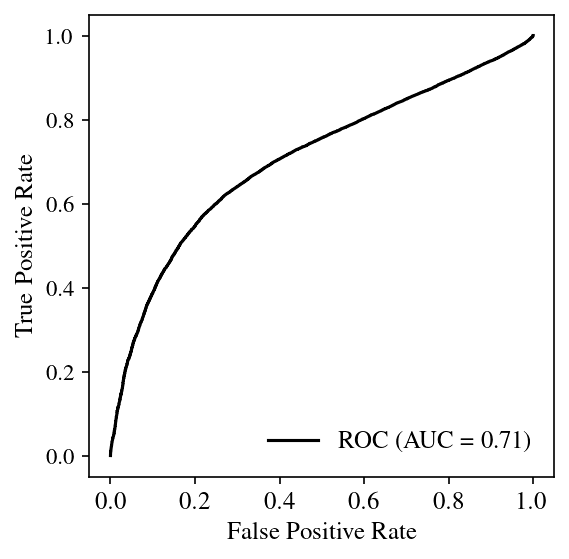

In [11]:
from rozlib.libs.plotting.plotting import plot_roc

"""
Look at ROC at word level using hhi or surprisal (the score is selected in prev cell)
"""


config_matplot_for_latex(12)

def make_roc_for_word_level(
        idioms_scores,
        literals_scores,
        use_surprisal: bool

):
    # Step 1: Combine scores and labels
    scores = np.array(idioms_scores + literals_scores)

    # if use_surprisal:
    #     # surprisal scores run the opposite direction (they are low for idioms)
    #     labels = np.array([0] * len(idioms_scores) + [1] * len(literals_scores))
    # else:
    # hhi scores are *high* for idioms
    labels = np.array([1] * len(idioms_scores) + [0] * len(literals_scores))


    # sampleing is unnecessary! TPR and FPR (for roc) are not affected by relatiave class sizes
    # print(sum(labels)/len(labels))
    # labels, scores = sample_evenly(labels, scores, 1000000)
    # print(sum(labels)/len(labels))

    fig = plot_roc(labels, scores,
             # flip_threshold_sign=use_surprisal,
             flip_threshold_sign=False,
             # title="ROC Curve Using Contextual Constraint",
             add_axes_labels=True,
             show_thresholds=False,
                   figsize=(4,4)
             )

    save_fig(fig, "idioms_roc.pdf")

# note that ROC is not affected by sample class imbalance!

make_roc_for_word_level(idioms_scores, literals_scores, use_surprisal)